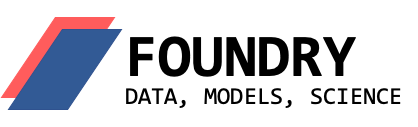

# Foundry OQMD Tutorial for Beginners
This introduction uses Foundry to:


1.   Load data from Foundry
2.   Create local metadata and dataframe


This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Installing Foundry
First we'll need to install Foundry and [MDF](https://materialsdatafacility.org/). If you're running the notebook locally, just make sure that Foundry and MDF are installed in your local environment. If you're using Google Colab, run the code below to install.

*Due to a recent FuncX update, we need to use FuncX 0.0.5 (FuncX is included in the Foundry install). This install is a temporary fix that makes sure we have the version we need.

In [ ]:
if IN_COLAB:
  !pip install foundry_ml
  !pip install mdf_connect_client
  !pip install funcx==0.0.5

# Importing and Instantiating Foundry
Now we can import Foundry!

In [3]:
from foundry import Foundry

We'll also need to instantiate it. To do so, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.

In [ ]:
if IN_COLAB:
  f = Foundry(no_local_server=True, no_browser=True) #instantiating in colab
else:
  f = Foundry() #instantiating locally

# Loading the Data
We can load the data using `f.load()` and use `f.load_data()` to load the data into the client.

In [ ]:
if IN_COLAB:
  f = f.load("_test_foundry_oqmd_v1.1", globus=False) #loading data in colab
else:
  f = f.load("_test_foundry_oqmd_v1.1") #loading data locally

In [6]:
X,y = f.load_data()

In [7]:
X.head()

,configuration,magnetic_moment,stability,delta_e,total_energy,volume_pa,composition,dft_converged,dft_cutoff_energy,dft_exchange_correlation_functional,crystal_structure_number_of_atoms,crystal_structure_space_group,crystal_structure_volume
0,fine_relax,NaN,NaN,NaN,-6.721376,14.4033,Be2Ir1Pa1,True,252.3,PBE,4,NaN,57.6133
1,standard,NaN,0.060465,-0.618895,-6.536939,20.4781,Ni1Pd1Y2,True,520.0,PBE,4,NaN,81.9125
2,fine_relax,0.412761,NaN,NaN,-5.988129,26.3910,Er2Ta1Tb1,True,223.7,PBE,4,NaN,105.5640
3,standard,1.603898,0.936115,0.936115,-5.704766,24.5555,K1Mn2Th1,True,520.0,PBE,4,NaN,98.2219
4,fine_relax,0.457712,NaN,NaN,-6.387080,25.4143,Pr2Si1Ta1,True,245.3,PBE,4,NaN,101.6570


We can also use `f.describe()` to see more information about the dataset, such as the creators, publisher, publication year, etc. You can see all the details below.

In [8]:
f.describe()

DC:{'creators': [{'affiliations': ['Northwestern University'], 'creatorName': 'Wolverton, Chris', 'familyName': 'Wolverton', 'givenName': 'Chris'}, {'affiliations': ['Northwestern University'], 'creatorName': 'Kirklin, Scott', 'familyName': 'Kirklin', 'givenName': 'Scott'}, {'affiliations': ['Northwestern University'], 'creatorName': 'Hegde, Vinay', 'familyName': 'Hegde', 'givenName': 'Vinay'}, {'affiliations': ['Northwestern University'], 'creatorName': 'Ward, Logan', 'familyName': 'Ward', 'givenName': 'Logan'}], 'dates': [{'date': '2021-01-28', 'dateType': 'Accepted'}], 'identifier': {'identifier': '10.23677/bnrj-obxh', 'identifierType': 'DOI'}, 'publicationYear': 2021, 'publisher': 'Materials Data Facility', 'resourceType': {'resourceType': 'Dataset', 'resourceTypeGeneral': 'Dataset'}, 'subjects': [{'subject': 'machine learning'}, {'subject': 'foundry'}], 'titles': [{'title': 'Foundry - OQMD'}]}
Dataset:{"inputs": ["configuration", "magnetic_moment", "stability", "delta_e", "total_e

# Run to Create Dataframe and Metadata Locally without Fetch

In [ ]:
if IN_COLAB:
  !pip install mdf-forge

In [ ]:
from mdf_forge.forge import Forge
import pandas as pd
import json

mdf = Forge()
r = mdf.match_source_names("oqmd").match_resource_types("record").search(limit=200)

In [16]:
def oqmd_to_df(res):
    frame = []
    
    for r in res:
        record = {}
        
        # OQMD Block
        record['bandgap'] = r['oqmd'].get('band_gap', {}).get('value', None)
        record['configuration'] = r['oqmd'].get('configuration', None)
        record['magnetic_moment'] = r['oqmd'].get('magnetic_moment',{}).get('value', None)
        record['stability'] = r['oqmd'].get('stability', {}).get('value', None)
        record['delta_e'] = r['oqmd'].get('delta_e', {}).get('value', None)
        record['total_energy'] = r['oqmd'].get('total_energy', {}).get('value', None)
        record['volume_pa'] = r['oqmd'].get('volume_pa', {}).get('value', None)
        
        # Material Block
        record['composition'] = r.get('material', {}).get('composition',"")
        
        #DFT Block
        prefix = "dft_"
        record[prefix+'converged'] = r['dft'].get('converged', None)
        record[prefix+'cutoff_energy'] = r['dft'].get('cutoff_energy', None)
        record[prefix+'exchange_correlation_functional'] = r['dft'].get('exchange_correlation_functional', None)
        
        # Crystal Structure Block
        prefix = "crystal_structure_"
        record[prefix+'number_of_atoms'] = r['crystal_structure'].get('number_of_atoms', None)
        record[prefix+'space_group'] = r['crystal_structure'].get('space_group', None)
        record[prefix+'volume'] = r['crystal_structure'].get('volume', None)

        frame.append(record)
    return frame

In [17]:
df = pd.DataFrame(oqmd_to_df(r))
df

,bandgap,configuration,magnetic_moment,stability,delta_e,total_energy,volume_pa,composition,dft_converged,dft_cutoff_energy,dft_exchange_correlation_functional,crystal_structure_number_of_atoms,crystal_structure_space_group,crystal_structure_volume
0,0.0,relaxation,NaN,NaN,NaN,-2.671297,17.6797,Li3Pb1,True,271.6,PBE,4,None,70.7190
1,0.0,standard,0.244548,0.336342,0.160264,-4.079219,13.9069,Co2Yb1Zn1,True,520.0,PBE,4,None,55.6276
2,0.0,fine_relax,0.641791,NaN,NaN,-3.098669,27.5637,K2Os1Pd1,True,259.2,PBE,4,None,110.2550
3,0.0,relaxation,NaN,NaN,NaN,-5.994711,9.2527,Mg1O1,True,400.0,PBE,4,None,37.0108
4,0.0,fine_relax,NaN,NaN,NaN,-4.426983,15.6735,Ag1Ga1Pd2,True,282.7,PBE,4,None,62.6938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,fine_relax,NaN,NaN,NaN,-2.691216,26.9258,Rb1Rh1Yb2,True,229.0,PBE,4,None,107.7030
196,0.0,fine_relax,NaN,NaN,NaN,-4.957691,16.1631,Ag1Ge1Pt2,True,287.6,PBE,4,None,64.6526
197,0.0,fine_relax,NaN,NaN,NaN,-3.994124,18.1895,Ce1Li2Pt1,True,271.6,PBE,4,None,72.7578
198,0.0,fine_relax,0.443384,NaN,NaN,-5.301720,16.7293,Au1Cu2U1,True,273.2,PBE,4,None,66.9173


In [18]:
df.to_json('foundry_dataframe.json')

In [14]:
oqmd_dict = {
    "dc":{},
    "mdf":{
        "source_id":"_test_foundry_oqmd_v1.1"
    },
    "foundry":{
        "inputs":['configuration',
             'magnetic_moment',
             'stability',
             'delta_e',
             'total_energy',
             'volume_pa',
             'composition',
             'dft_converged',
             'dft_cutoff_energy',
             'dft_exchange_correlation_functional',
             'crystal_structure_number_of_atoms',
             'crystal_structure_space_group',
             'crystal_structure_volume'],
        "outputs":"bandgap",
        "type":"tabular"
    }
}

In [ ]:
with open('foundry_metadata.json', 'w') as meta_file:
  json.dump(oqmd_dict, meta_file)